# Simple Image Compression Using Quadtree


From the path planning for robotic vacuum cleaner to the mesh generation in VLSI simulation, spatial data and their applications are everywhere. 
How to represent the spatial data efficiently is being extensively studied. 
Among the popular techniques, quadtree is one of the widely used data structure for representation of multi-dimensional spatial data. 

A classic quatree is formed by representing a square region being considered as the root of a tree. 
Next, the given region is divided into four equal-sized non-overlapping subregions by bisecting the region along each dimension. 
The four subregions produces four nodes associated to their parent node. 
The procedure of subdivision is performed recursively until a predefined minimum size of region or the criterion of the spatial homogeneity is reached. The figure below depicts the process.

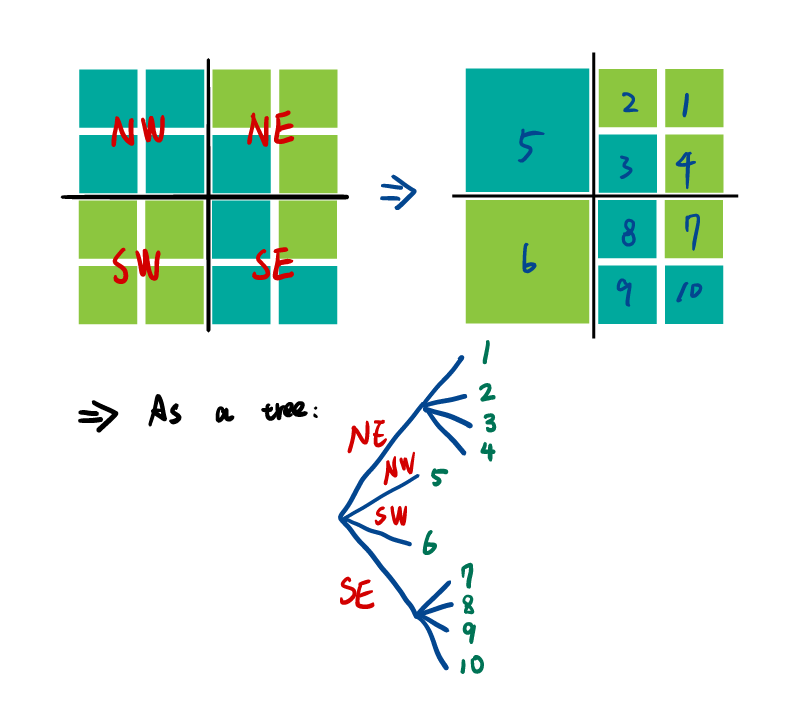

Due to the advantages of conceptual clarity and ease of implementation, 
hundreds of variations and applications related to quadtree have been proposed since the introduction of the idea by Finkel and Bentley in 1974. 

In the following section, we are going to use Python to implement a quadtree and use it in lossy image compression as an simple example. We will use the colorful 512 x 512 "Mandrill" image as a example. The image can be obtained from [USC-SIPI Image Database].


[USC-SIPI Image Database]: http://sipi.usc.edu/database/database.php?volume=misc  "source"

Let us dive into the code.

First, we import all the dependencies.

In [1]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

We use the `imageio.imread()` to load the image as a numpy array. The 2-D image is represented by a 3-D array. The first dimension is height, the second dimension is width, and the third dimension is a 3-components vector contains the RGB values of the corresponding pixel.

In [2]:
data = imread("mandrill.tiff")

Have a look at it:

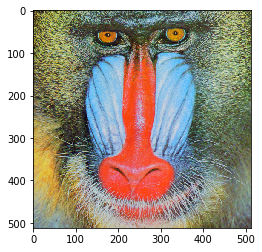

In [3]:
fig = plt.figure()
plt.imshow(data)
plt.show()

Next, we implement the quadtree as a class. The method `QuadTree.subdivide` subdivides given data into blocks until a minimum size of subdivision is reached or the function `similarity_func`, which validates the spatial homogeneity of the subdivision, returns `True`. In order to make the criterion of similarity validation flexible, we make the method `QuadTree.subdivide` accept an argument `similarity_func`, so that the function could be defined later.

In [4]:
class QuadTree:
    class Node:
        def __init__(self, x, y, data):
            x = self._convert_int(x)
            y = self._convert_int(y)

            self.x = x
            self.y = y
            self.data = data
            self.children = []
            
        @property
        def shape(self):
            return self.data.shape

        def __repr__(self):
            return "Node(x={0}, y={1}, shape={2})".format(self.x, self.y, self.shape)
        
        def _convert_int(self, x):
            if type(x) is not int:
                x = int(x)
                
            return x
    
    def __init__(self, data):
        x = 0
        y = 0
        self.root = self.Node(x, y, data)
        
    def subdivide(self, similarity_func, args=(), min_size=(1, 1)):
        if not isinstance(args, tuple):
            args = (args,)
        
        def _subdivide(node):
            data_reshaped = node.data.reshape((-1, 3))
            if (data_reshaped.shape[0] <= min_size[0] 
                or data_reshaped.shape[1] <= min_size[1] 
                or similarity_func(data_reshaped, *args)):
                return
            
            x_mid = (node.data.shape[0] - 1) // 2 + 1
            y_mid = (node.data.shape[1] - 1) // 2 + 1

            data_sw = node.data[0:x_mid, 0:y_mid]
            if data_sw.shape[0] >= min_size[0] and data_sw.shape[1] >= min_size[1]:
                x_sw = float(node.x)
                y_sw = node.y
                node_sw = self.Node(x_sw, y_sw, data_sw)
                _subdivide(node_sw)
                node.children.append(node_sw)

            data_se = node.data[x_mid:, 0:y_mid]
            if data_se.shape[0] >= min_size[0] and data_se.shape[1] >= min_size[1]:
                x_se = node.x + x_mid
                y_se = node.y
                node_se = self.Node(x_se, y_se, data_se)
                _subdivide(node_se)
                node.children.append(node_se)
            
            data_nw = node.data[0:x_mid, y_mid:]
            if data_nw.shape[0] >= min_size[0] and data_nw.shape[1] >= min_size[1]:
                x_nw = node.x
                y_nw = node.y + y_mid
                node_nw = self.Node(x_nw, y_nw, data_nw)
                _subdivide(node_nw)
                node.children.append(node_nw)

            data_ne = node.data[x_mid:, y_mid:]
            if data_ne.shape[0] >= min_size[0] and data_ne.shape[1] >= min_size[1]:
                x_ne = node.x + x_mid
                y_ne = node.y + y_mid
                node_ne = self.Node(x_ne, y_ne, data_ne)
                _subdivide(node_ne)
                node.children.append(node_ne)
                
        _subdivide(self.root)
        
    @property
    def leaves(self):
        _leaves = []
        
        def _get_leaves(node):
            if len(node.children) == 0:
                _leaves.append(node)
                return
            for c in node.children:
                _get_leaves(c)
                
        _get_leaves(self.root)
        return _leaves
        

The strategy here is quite simple. We use QuadTree to examine and subdivide the input image. If the color of pixels in a subdivision resembles each other enough, we consider the subdivision as homogeneous and make the subdivision as a leaf of the quadtree.

To find the similarity of the colors, we measure the color distance between two pixels within a color space by using Euclidean distance. A quick implementation would be simply measure the distance between two vectors of RGB, $[r_1, g_1, b_1]$ and $[r_2, g_2, b_2]$:

$$
\text{distance} = \sqrt{(r_1 - r_2)^2 + (g_1 - g_2)^2 + (b_1 - b_2)^2}
$$


There is still one concern. The response of the human vision system for each color is not uniform across the spectrum of visible regime. As the figure shown below, the sensitivity of human vision to different colors varies dramatically.


(Eye sensitivity diagram. Image source: https://en.wikipedia.org/wiki/Color_vision#/media/File:Eyesensitivity.svg)

Here, we shall use a common technique used in video industry, converting the color vector from RGB space to a more perceptually uniform color space, YUV space. 


$$
\begin{align}
\begin{bmatrix} 
Y  \\
U \\
V
\end{bmatrix} = 
\begin{bmatrix} 
0.299 & 0.587 & 0.114  \\
-0.14713 & -0.28886 & 0.463 \\
0.615 & -0.51499 & -0.10001
\end{bmatrix}
\begin{bmatrix} 
R  \\
G \\
B
\end{bmatrix},
\end{align}
$$

The color vector can be converted back to RGB space by

$$
\begin{align}
\begin{bmatrix} 
R  \\
G \\
B
\end{bmatrix} = 
\begin{bmatrix} 
1 & 0 & 1.13983  \\
1 & -0.39465 & -0.58060 \\
1 & 2.03211 & 0
\end{bmatrix}
\begin{bmatrix} 
Y  \\
U \\
V
\end{bmatrix},
\end{align}
$$

Now, we are ready to define our metric function of color similarity for a given set of colors in YUV space, $s=\{[Y_i, U_i, V_i]^T : i \in Z \text{ and } i \in [1, N] \}$, as measuring the Euclidean distance, $d$, of the standard deviation of Y, U, and V components of given colors:

$$
d(s) = \sqrt{\sigma(Y)^2 + \sigma(U)^2 + \sigma(V)^2}
$$

The colors in a given color set are $d(s) < R$, where $R$ is an user-defined tolerance. One could imagine that the we are validating the similarity by checking if the standard deviations of given colors is inside a circle of radius $R$ 

Below is the code of the functions for converting color vector back and forth between RGB and YUV color spaces and the metric function $d(s)$:

In [8]:
def rgb_to_yuv(v_rgb):
    v_rgb = v_rgb.reshape((-1, 3))
    m = [[0.299, 0.587, 0.114],
         [-0.14713, -0.28886, 0.463],
         [0.615, -0.51499, -0.10001]]
    m = np.array(m)
    v_yuv = np.matmul(m, v_rgb.T).T
    return v_yuv

def yuv_to_rgb(v_yuv):
    v_yuv = v_yuv.reshape((-1, 3))
    m = [[1, 0, 1.13983],
         [1, -0.39465, -0.58060],
         [1, 2.03211, 0]]
    m = np.array(m)
    v_rgb = np.matmul(m, v_yuv.T).T
    return v_rgb
    
def validate_similar(c, tolerance):
    c = c.reshape((-1, 3))
    c_yuv = rgb_to_yuv(c)
    c_std = np.std(c_yuv, axis=0)
    is_similar = np.sqrt(np.sum(c_std ** 2.0)) < tolerance

    return is_similar


Now that we've got the basic functions defined. Let's apply it on the Mandrill image and see how well it does by using the tolerance of $10$.

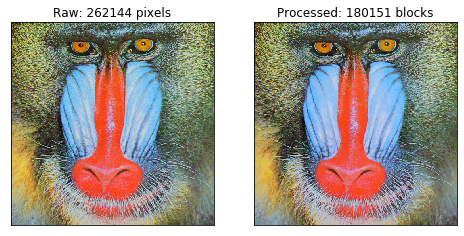

In [9]:
qt = QuadTree(data)
qt.subdivide(validate_similar, args=(10,))

# plot the raw data
fig = plt.subplots(figsize=(8, 4))
ax = plt.subplot2grid((1, 2), (0, 0))
ax.set_title("Raw: {0} pixels".format(data.shape[0] * data.shape[1]))
ax.imshow(data)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


# plot the processed data
patches = []
for leaf in qt.leaves:
    m_yuv = rgb_to_yuv(leaf.data)
    yuv_mean = np.mean(m_yuv, axis=0)
    rgb_mean = yuv_to_rgb(yuv_mean)
    rgb_mean[rgb_mean > 256] = 256
    rgb_mean[rgb_mean < 0] = 0
    r, g, b = rgb_mean.flatten() / 256
    rect = mpatches.Rectangle((leaf.y, leaf.x), width=leaf.shape[1], height=leaf.shape[0], ec="none", color=(r, g, b), lw=0.2)
    patches.append(rect)

collection = PatchCollection(patches, match_original=True)

ax = plt.subplot2grid((1, 2), (0, 1))
ax.set_title("Processed: {0} blocks".format(len(qt.leaves)))
ax.add_collection(collection)
ax.set_aspect('equal')
ax.set_xlim((0, data.shape[1]))
ax.set_ylim((data.shape[0], 0))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

We find the difference between the original image and processed one is hardly noticeable. However, the compressed data use about 30% less blocks!